## Import Packages

In [1]:
from abc import ABC, abstractmethod
from typing import List
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModelForCausalLM, ViltProcessor, ViltForQuestionAnswering
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from models.vilt import VILTModel
from models.git import GitModel
from trainer.singlemodeltrainer import Trainer
from trainer.jointmodeltrainer import JointTrainer

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
url_eiffel = "https://www.travelandleisure.com/thmb/SPUPzO88ZXq6P4Sm4mC5Xuinoik=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/eiffel-tower-paris-france-EIFFEL0217-6ccc3553e98946f18c893018d5b42bde.jpg"
url_obama = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/440px-President_Barack_Obama.jpg"
url_cat = "http://images.cocodataset.org/val2017/000000039769.jpg"
url_lion = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/1200px-Lion_waiting_in_Namibia.jpg"
url_dog = "https://www.princeton.edu/sites/default/files/styles/1x_full_2x_half_crop/public/images/2022/02/KOA_Nassau_2697x1517.jpg?"

In [11]:
image = Image.open(requests.get(url_obama, stream=True).raw)
image1 = Image.open(requests.get(url_cat, stream=True).raw)
image2 = Image.open(requests.get(url_eiffel, stream=True).raw)
image_dog = Image.open(requests.get(url_dog, stream=True).raw)

In [12]:
b = GitModel()
b.target = "cat"

In [13]:
a = VILTModel()
a.target = "cat"

In [14]:
t1 = Trainer(model = a, images=[image_dog], texts=["Wat animal is in the image?"],  epochs=100)

In [15]:
t2 = Trainer(model = b, images=[image_dog], texts=["Wat animal is in the image?"], epochs=500)

In [16]:
t3 = JointTrainer(models=[b, a], images=[image_dog], texts=['Wat animal is in the image?'], epochs=50)

## Load Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("cats_vs_dogs", ignore_verifications=True)
cat_dataset = dataset.filter(lambda example: example["labels"] == 0)['train'].select(range(50))
dog_dataset = dataset.filter(lambda example: example["labels"] == 1)['train'].select(range(50))

## Joint Model Adversaries Training

In [ ]:
num_epochs = 100
delta_values = [0.02, 0.5, 1.0, 1.5, 2.0,]

for delta in delta_values:
    adversaries = []
    deltas = []
    from tqdm.auto import tqdm
    for sample in tqdm(dog_dataset):
        t = JointTrainer(
          models=[b, a],
          images=[sample['image']],
          texts=['Name one object in the image'],
          epochs=num_epochs,
          delta = delta
        )
        change, image = t.train()
        deltas.append(change)
        adversaries.append(image)
    torch.save(adversaries, f'joint/adversaries_epsilon_{delta}.pt')
    torch.save(deltas, f'joint/deltas_epsilon_{delta}.pt')    

## Single Model Adversaries Training

In [ ]:
num_epochs = 100
delta_values = [0.02, 0.5, 1.0, 1.5, 2.0,]

for delta in delta_values:
    adversaries = []
    deltas = []
    from tqdm.auto import tqdm
    for sample in tqdm(dog_dataset):
        # t = JointTrainer(
        #   models=[b, a],
        #   images=[sample['image']],
        #   texts=['Name one object in the image'],
        #   epochs=num_epochs,
        #   delta = delta
        # )
        t = Trainer(
          model=b,
          images=[sample['image']],
          texts=['Name one object in the image'],
          epochs=num_epochs,
          delta = delta
        )
        change, image = t.train()
        deltas.append(change)
        adversaries.append(image)
    torch.save(adversaries, f'single/adversaries_epsilon_{delta}.pt')
    torch.save(deltas, f'single/deltas_epsilon_{delta}.pt')    

## Transferability Analysis

### Pix2Struct

In [ ]:
import torch

adversaries = torch.load('joint/adversaries_0.05.pt')
deltas = torch.load('joint/deltas_0.05.pt')


In [77]:
from PIL import Image
import requests
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

pix2struct_processor = AutoProcessor.from_pretrained("google/pix2struct-textcaps-base")
pix2struct_model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-textcaps-base")

# conditional generation
image = Image.open(requests.get(url_dog, stream=True).raw)
question = 'the animal in the picture is a'


In [78]:
pix2struct_model = pix2struct_model.cuda()

In [79]:
inputs = pix2struct_processor(text=question, images=sample['image'], return_tensors="pt", add_special_tokens=False)
for k in inputs:
    inputs[k] = inputs[k].cuda()
outputs = pix2struct_model.generate(**inputs, max_new_tokens=50, output_scores=True, return_dict_in_generate=True)
generated_text = pix2struct_processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
generated_text

'the animal in the picture is a dog'

In [29]:
from datasets import load_dataset
dataset = load_dataset("cats_vs_dogs", ignore_verifications=True)
cat_dataset = dataset.filter(lambda example: example["labels"] == 0)['train'].select(range(50))
dog_dataset = dataset.filter(lambda example: example["labels"] == 1)['train'].select(range(50))

/n/home13/stanneru/.local/lib/python3.8/site-packages/datasets/load.py:2096: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [80]:
prob_scores = []
for sample in dog_dataset:
    inputs = pix2struct_processor(text=question, images=sample['image'], return_tensors="pt", add_special_tokens=False)
    for k in inputs:
        inputs[k] = inputs[k].cuda()
    outputs = pix2struct_model.generate(**inputs, max_new_tokens=50, output_scores=True, return_dict_in_generate=True)
    generated_text = pix2struct_processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
    prob_scores.append(np.max([torch.nn.functional.softmax(scores, dim=-1)[0][2568].detach().cpu().item() for scores in outputs.scores]))
    if "cat" in generated_text:
        print(generated_text)
    if "dog" in generated_text:
        print(generated_text)
print(np.mean(prob_scores))

the animal in the picture is a cat
the animal in the picture is a dog
the animal in the picture is a cat
the animal in the picture is a black and white dog
the animal in the picture is a red and white dog
the animal in the picture is a cat
the animal in the picture is a cat
the animal in the picture is a cat
the animal in the picture is a dog
the animal in the picture is a cat
the animal in the picture is a cat
the animal in the picture is a cat
the animal in the picture is a cat
the animal in the picture is a cat
the animal in the picture is a dog
the animal in the picture is a cat
the animal in the picture is a dog
the animal in the picture is a black and white dog
the animal in the picture is a dog
0.04191808953881264


In [71]:
outputs

['the animal in the picture is say whaaat']

In [83]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    adversaries = torch.load(f'joint/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'joint/deltas_epsilon_{epsilon}.pt')

    count_cat = 0
    count_dog = 0
    prob_scores = []

    for image_input in adversaries:
        inputs = pix2struct_processor(text=question, images=image_input, return_tensors="pt", add_special_tokens=False)
        for k in inputs:
            inputs[k] = inputs[k].cuda()
        outputs = pix2struct_model.generate(**inputs, max_new_tokens=50, output_scores=True, return_dict_in_generate=True)
        generated_text = pix2struct_processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
        prob_scores.append(np.max([torch.nn.functional.softmax(scores, dim=-1)[0][2568].detach().cpu().item() for scores in outputs.scores]))
        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} score: {np.mean(prob_scores)}")

epsilon: 0.02 cat: 8 dog: 5 score: 0.03517620539292693
epsilon: 0.5 cat: 2 dog: 4 score: 0.03283939986489713
epsilon: 1.0 cat: 2 dog: 3 score: 0.03471201779320836
epsilon: 1.5 cat: 2 dog: 4 score: 0.034952492974698546
epsilon: 2.0 cat: 3 dog: 4 score: 0.0357971216365695


In [82]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    adversaries = torch.load(f'single/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'single/deltas_epsilon_{epsilon}.pt')

    count_cat = 0
    count_dog = 0
    prob_scores = []

    for image_input in adversaries:
        inputs = pix2struct_processor(text=question, images=image_input, return_tensors="pt", add_special_tokens=False)
        for k in inputs:
            inputs[k] = inputs[k].cuda()
        outputs = pix2struct_model.generate(**inputs, max_new_tokens=50, output_scores=True, return_dict_in_generate=True)
        generated_text = pix2struct_processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
        prob_scores.append(np.max([torch.nn.functional.softmax(scores, dim=-1)[0][2568].detach().cpu().item() for scores in outputs.scores]))
        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} score: {np.mean(prob_scores)}")

epsilon: 0.02 cat: 7 dog: 5 score: 0.03565662675537169
epsilon: 0.5 cat: 7 dog: 5 score: 0.0356192431319505
epsilon: 1.0 cat: 7 dog: 5 score: 0.0356192431319505
epsilon: 1.5 cat: 7 dog: 5 score: 0.0356192431319505
epsilon: 2.0 cat: 7 dog: 5 score: 0.0356192431319505


### ViLT

In [42]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

vilt_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vilt_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
question = 'Name one object in the image'
image = Image.open(requests.get(url_obama, stream=True).raw)
encoding = vilt_processor(image, question, return_tensors="pt")
encoding['input_ids'] = encoding['input_ids']
encoding['pixel_values'] = image_input.cpu()

# forward pass
outputs = vilt_model(**encoding)
logits = outputs.logits
logits = torch.nn.functional.softmax(logits, dim=-1)
idx = logits.argmax(-1).item()
print(f"cat probability: {logits[0, 211]}")
print("Predicted answer:", vilt_model.config.id2label[idx])

cat probability: 0.000938972516451031
Predicted answer: dog


In [44]:
count_cat = 0
count_dog = 0

question = 'Name one object in the image'
prob_scores = []
for sample in dog_dataset:
    encoding = vilt_processor(sample['image'], question, return_tensors="pt")
    # forward pass
    outputs = vilt_model(**encoding)
    logits = outputs.logits
    logits = torch.nn.functional.softmax(logits, dim=-1)
    prob_scores.append(logits[0, 211].item())
    idx = logits.argmax(-1).item()
    generated_text = vilt_model.config.id2label[idx]
    if "cat" in generated_text:
        count_cat += 1
    if "dog" in generated_text:
        count_dog += 1
print(f"cat: {count_cat} dog: {count_dog} score: {np.mean(prob_scores)}")

cat: 0 dog: 44 score: 0.008653817700396757


In [46]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    adversaries = torch.load(f'joint/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'joint/deltas_epsilon_{epsilon}.pt')
    count_cat = 0
    count_dog = 0
    print(f"epsilon: {epsilon}")
    prob_scores = []
    for image_input in adversaries:
        # prepare inputs
        question = 'Name one object in the image'
        encoding = vilt_processor(image, question, return_tensors="pt")
        encoding['input_ids'] = encoding['input_ids']
        encoding['pixel_values'] = image_input.cpu()
        # forward pass
        outputs = vilt_model(**encoding)
        logits = outputs.logits
        logits = torch.nn.functional.softmax(logits, dim=-1)
        prob_scores.append(logits[0, 211].item())
        idx = logits.argmax(-1).item()
        generated_text = vilt_model.config.id2label[idx]

        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} score: {np.mean(prob_scores)}")

epsilon: 0.02
epsilon: 0.02 cat: 49 dog: 1 score: 0.971150403097272
epsilon: 0.5
epsilon: 0.5 cat: 50 dog: 0 score: 0.9997778224945069
epsilon: 1.0
epsilon: 1.0 cat: 50 dog: 0 score: 0.9997886896133423
epsilon: 1.5
epsilon: 1.5 cat: 50 dog: 0 score: 0.9997888839244843
epsilon: 2.0
epsilon: 2.0 cat: 50 dog: 0 score: 0.999786707162857


In [48]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    adversaries = torch.load(f'single/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'single/deltas_epsilon_{epsilon}.pt')
    count_cat = 0
    count_dog = 0
    print(f"epsilon: {epsilon}")
    prob_scores = []
    for image_input in adversaries:
        # prepare inputs
        question = 'Name one object in the image'
        encoding = vilt_processor(image, question, return_tensors="pt")
        encoding['input_ids'] = encoding['input_ids']
        encoding['pixel_values'] = image_input.cpu()
        # forward pass
        outputs = vilt_model(**encoding)
        logits = outputs.logits
        logits = torch.nn.functional.softmax(logits, dim=-1)
        prob_scores.append(logits[0, 211].item())
        idx = logits.argmax(-1).item()
        generated_text = vilt_model.config.id2label[idx]

        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} score: {np.mean(prob_scores)}")

epsilon: 0.02
epsilon: 0.02 cat: 0 dog: 46 score: 0.01047250545823772
epsilon: 0.5
epsilon: 0.5 cat: 0 dog: 47 score: 0.010584701537591173
epsilon: 1.0
epsilon: 1.0 cat: 0 dog: 47 score: 0.010584695312718394
epsilon: 1.5
epsilon: 1.5 cat: 0 dog: 47 score: 0.010584715711156606
epsilon: 2.0
epsilon: 2.0 cat: 0 dog: 47 score: 0.010584700612089364


### GiT

In [25]:
from transformers import AutoProcessor, AutoModelForCausalLM
from huggingface_hub import hf_hub_download
from PIL import Image

git_processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
git_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

pixel_values = git_processor(images=image, return_tensors="pt").pixel_values
# pixel_values = image_input.cpu()

question = 'what animal is in the image ?'

input_ids = git_processor(text=question, add_special_tokens=False).input_ids
input_ids = [git_processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

outputs = git_model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50, output_scores=True, return_dict_in_generate=True)
print(git_processor.batch_decode(outputs.sequences, skip_special_tokens=True))

['what animal is in the image? president']


In [26]:
git_processor(text="cat", add_special_tokens=False).input_ids

[4937]

In [27]:
git_model = git_model.cuda()

In [30]:
count_cat = 0
count_dog = 0

question = 'Name one object in the image'
prob_scores = []
for sample in dog_dataset:
    image = sample['image']
    if not torch.is_tensor(image):
        image = git_processor.image_processor(images=image, return_tensors="pt").pixel_values.to(device)
    input_tokens = git_processor(text=question, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    outputs = git_model.generate(pixel_values=image, input_ids=input_tokens, max_length=50, output_scores=True, return_dict_in_generate=True)
    generated_text = git_processor.tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
    
    # generated_text = git_processor.batch_decode(generated_ids, skip_special_tokens=True)
    # print(f"generated_text: {generated_text}")
    
    prob_scores.append(np.max([torch.nn.functional.softmax(scores, dim=-1)[0][4937].detach().cpu().item() for scores in outputs.scores]))

    if "cat" in generated_text:
        count_cat += 1
    if "dog" in generated_text:
        count_dog += 1
print(f"cat: {count_cat} dog: {count_dog} prob: {np.mean(prob_scores)}")

cat: 0 dog: 0 prob: 1.2520674526967924e-05


In [31]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    prob_scores = []
    adversaries = torch.load(f'joint/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'joint/deltas_epsilon_{epsilon}.pt')
    count_cat = 0
    count_dog = 0
    question = 'Name one object in the image'
    print(f"epsilon: {epsilon}")
    for image_input in adversaries:
        input_tokens = git_processor(text=question, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
        outputs = git_model.generate(pixel_values=image_input, input_ids=input_tokens, max_length=50, output_scores=True, return_dict_in_generate=True)
        generated_text = git_processor.tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
        prob_scores.append(np.max([torch.nn.functional.softmax(scores, dim=-1)[0][4937].detach().cpu().item() for scores in outputs.scores]))
        # print(f"generated_text: {generated_text}")

        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} prob: {np.mean(prob_scores)}")

epsilon: 0.02
epsilon: 0.02 cat: 50 dog: 0 prob: 0.001241102189887897
epsilon: 0.5
epsilon: 0.5 cat: 50 dog: 0 prob: 0.0019335399822739418
epsilon: 1.0
epsilon: 1.0 cat: 50 dog: 0 prob: 0.0020027533997199498
epsilon: 1.5
epsilon: 1.5 cat: 50 dog: 0 prob: 0.002188363154855324
epsilon: 2.0
epsilon: 2.0 cat: 50 dog: 0 prob: 0.002079417980858125


In [34]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    prob_scores = []
    adversaries = torch.load(f'single/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'single/deltas_epsilon_{epsilon}.pt')
    count_cat = 0
    count_dog = 0
    question = 'Name one object in the image'
    print(f"epsilon: {epsilon}")
    for image_input in adversaries:
        input_tokens = git_processor(text=question, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
        outputs = git_model.generate(pixel_values=image_input, input_ids=input_tokens, max_length=50, output_scores=True, return_dict_in_generate=True)
        generated_text = git_processor.tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
        prob_scores.append(np.max([torch.nn.functional.softmax(scores, dim=-1)[0][4937].detach().cpu().item() for scores in outputs.scores]))
        # print(f"generated_text: {generated_text}")

        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} prob: {np.mean(prob_scores)}")

epsilon: 0.02
epsilon: 0.02 cat: 50 dog: 0 prob: 0.00172806291928282
epsilon: 0.5
epsilon: 0.5 cat: 50 dog: 0 prob: 0.0016263190045719966
epsilon: 1.0
epsilon: 1.0 cat: 50 dog: 0 prob: 0.0016263190045719966
epsilon: 1.5
epsilon: 1.5 cat: 50 dog: 0 prob: 0.0016263190045719966
epsilon: 2.0
epsilon: 2.0 cat: 50 dog: 0 prob: 0.0016263190045719966


### Bridge Tower LM

In [ ]:
from transformers import BridgeTowerProcessor, BridgeTowerForMaskedLM
from PIL import Image
import torch.nn.functional as F
import requests

bridge_tower_processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base-itm-mlm")
bridge_tower_model = BridgeTowerForMaskedLM.from_pretrained("BridgeTower/bridgetower-base-itm-mlm")


In [ ]:
# initialize question
question = 'the animal in the image is a <mask>'

# prepare inputs
image = Image.open(requests.get(url_dog, stream=True).raw)
encoding = bridge_tower_processor(image, question, return_tensors="pt")
encoding['pixel_values'] = F.interpolate(image_input.cpu(), size=288, mode='bilinear', align_corners=False)
encoding['pixel_values'] = image_input[:, :, 96:-96, 96:-96].cpu()

# forward pass
outputs = bridge_tower_model(**encoding)

results = bridge_tower_processor.decode(outputs.logits.argmax(dim=-1).squeeze(0).tolist())

print(results)

In [ ]:
bridge_tower_processor.tokenizer("cat", add_special_tokens=False)

In [ ]:
bridge_tower_processor.tokenizer(["the animal in the image is a <mask>"])

In [ ]:
count_cat = 0
count_dog = 0

question = 'the animal in the image is a <mask>'
prob_scores = []
for sample in dog_dataset:
    image = sample['image']
    encoding = bridge_tower_processor(image, question, return_tensors="pt")
    outputs = bridge_tower_model(**encoding)
    generated_text = bridge_tower_processor.decode(outputs.logits.argmax(dim=-1).squeeze(0).tolist())
    prob_scores.append(torch.max(torch.nn.functional.softmax(outputs.logits[0], dim=-1)[8:][:, 8729]).detach().cpu().item())

    if "cat" in generated_text:
        count_cat += 1
    if "dog" in generated_text:
        count_dog += 1
print(f"cat: {count_cat} dog: {count_dog} prob: {np.mean(prob_scores)}")

In [ ]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    prob_scores = []
    adversaries = torch.load(f'joint/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'joint/deltas_epsilon_{epsilon}.pt')
    count_cat = 0
    count_dog = 0
    question = 'the animal in the image is a <mask>'
    print(f"epsilon: {epsilon}")
    for image_input in adversaries:
        encoding = bridge_tower_processor(image, question, return_tensors="pt")
        encoding['pixel_values'] = F.interpolate(image_input.cpu(), size=288, mode='bilinear', align_corners=False)
        encoding['pixel_values'] = image_input[:, :, 96:-96, 96:-96].cpu()
        outputs = bridge_tower_model(**encoding)
        generated_text = bridge_tower_processor.decode(outputs.logits.argmax(dim=-1).squeeze(0).tolist())
        prob_scores.append(torch.max(torch.nn.functional.softmax(outputs.logits[0], dim=-1)[8:][:, 8729]).detach().cpu().item())
        # print(f"generated_text: {generated_text}")

        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} prob: {np.mean(prob_scores)}")

In [ ]:
for epsilon in [0.02, 0.5, 1.0, 1.5, 2.0]:
    prob_scores = []
    adversaries = torch.load(f'single/adversaries_epsilon_{epsilon}.pt')
    deltas = torch.load(f'single/deltas_epsilon_{epsilon}.pt')
    count_cat = 0
    count_dog = 0
    question = 'the animal in the image is a <mask>'
    print(f"epsilon: {epsilon}")
    for image_input in adversaries:
        encoding = bridge_tower_processor(image, question, return_tensors="pt")
        encoding['pixel_values'] = F.interpolate(image_input.cpu(), size=288, mode='bilinear', align_corners=False)
        encoding['pixel_values'] = image_input[:, :, 96:-96, 96:-96].cpu()
        outputs = bridge_tower_model(**encoding)
        generated_text = bridge_tower_processor.decode(outputs.logits.argmax(dim=-1).squeeze(0).tolist())
        prob_scores.append(torch.max(torch.nn.functional.softmax(outputs.logits[0], dim=-1)[8:][:, 8729]).detach().cpu().item())
        # print(f"generated_text: {generated_text}")

        if "cat" in generated_text:
            count_cat += 1
        if "dog" in generated_text:
            count_dog += 1
    print(f"epsilon: {epsilon} cat: {count_cat} dog: {count_dog} prob: {np.mean(prob_scores)}")

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(12.5, 10))

for idx, image_input in enumerate(adversaries):
  adversarial_image = image_input.detach().cpu().numpy()[0]
  adversarial_image = adversarial_image.transpose(1, 2, 0)
  ax[idx // 4][idx % 4].imshow(adversarial_image)
  ax[idx // 4][idx % 4].axis('off')
fig.tight_layout()
plt.title('delta = 0.05')

In [ ]:
adversarial_image = image_input.detach().cpu().numpy()[0]
adversarial_image = adversarial_image.transpose(1, 2, 0)
adversarial_image.shape

In [ ]:
plt.imshow(adversarial_image)

### Plots - Transferability

In [62]:
import matplotlib.pyplot as plt
import numpy as np

transfer_data = {
    "GiT": {
        "cat_joint": [0, 50, 50, 50, 50, 50],
        "cat_single": [0, 50, 50, 50, 50, 50],
        "dog_joint": [0, 0, 0, 0, 0, 0],
        "dog_single": [0, 0, 0, 0, 0, 0],
        "prob_joint": [1.25e-05, 0.00124110219, 0.001933539982, 0.0020027534, 0.002188363155, 0.002079417981],
        "prob_single": [1.25e-05, 0.001728062919, 0.001626319005, 0.001626319005, 0.001626319005, 0.001626319005],
    },
    "ViLT": {
        "cat_joint": [0, 49, 50, 50, 50, 50],
        "cat_single": [0, 0, 0, 0, 0, 0],
        "dog_joint": [44, 1, 0, 0, 0, 0],
        "dog_single": [44, 46, 47, 47, 47, 47],
        "prob_joint": [0.0086538177, 0.9711504031, 0.9997778225, 0.9997886896, 0.9997888839, 0.9997867072],
        "prob_single": [0.0086538177, 0.01047250546, 0.01058470154, 0.01058469531, 0.01058471571, 0.01058470061],
    },
    "Pix2Struct": {
        "cat_joint": [11, 8, 2, 2, 2, 3],
        "cat_single": [11, 7, 7, 7, 7, 7],
        "dog_joint": [8, 5, 4, 3, 4, 4],
        "dog_single": [8, 12, 12, 12, 12, 12],
        "prob_joint": [4.19e-02, 0.03517620539, 0.03283939986, 0.03471201779, 0.03495249297, 0.03579712164],
        "prob_single": [4.19e-02, 0.03565662676, 0.03561924313, 0.03561924313, 0.03561924313, 0.03561924313],
    },
    "Bridge Tower LM": {
        "cat_joint": [0, 1, 7, 8, 8, 9],
        "cat_single": [0, 1, 1, 1, 1, 1],
        "dog_joint": [45, 44, 29, 26, 27, 25],
        "dog_single": [45, 46, 46, 46, 46, 46],
        "prob_joint": [2.04e-06, 5.58e-06, 2.78e-05, 2.65e-05, 3.40e-05, 3.14e-05],
        "prob_single": [2.04e-06, 5.87e-06, 5.12e-06, 5.12e-06, 5.12e-06, 5.12e-06],
    }
}


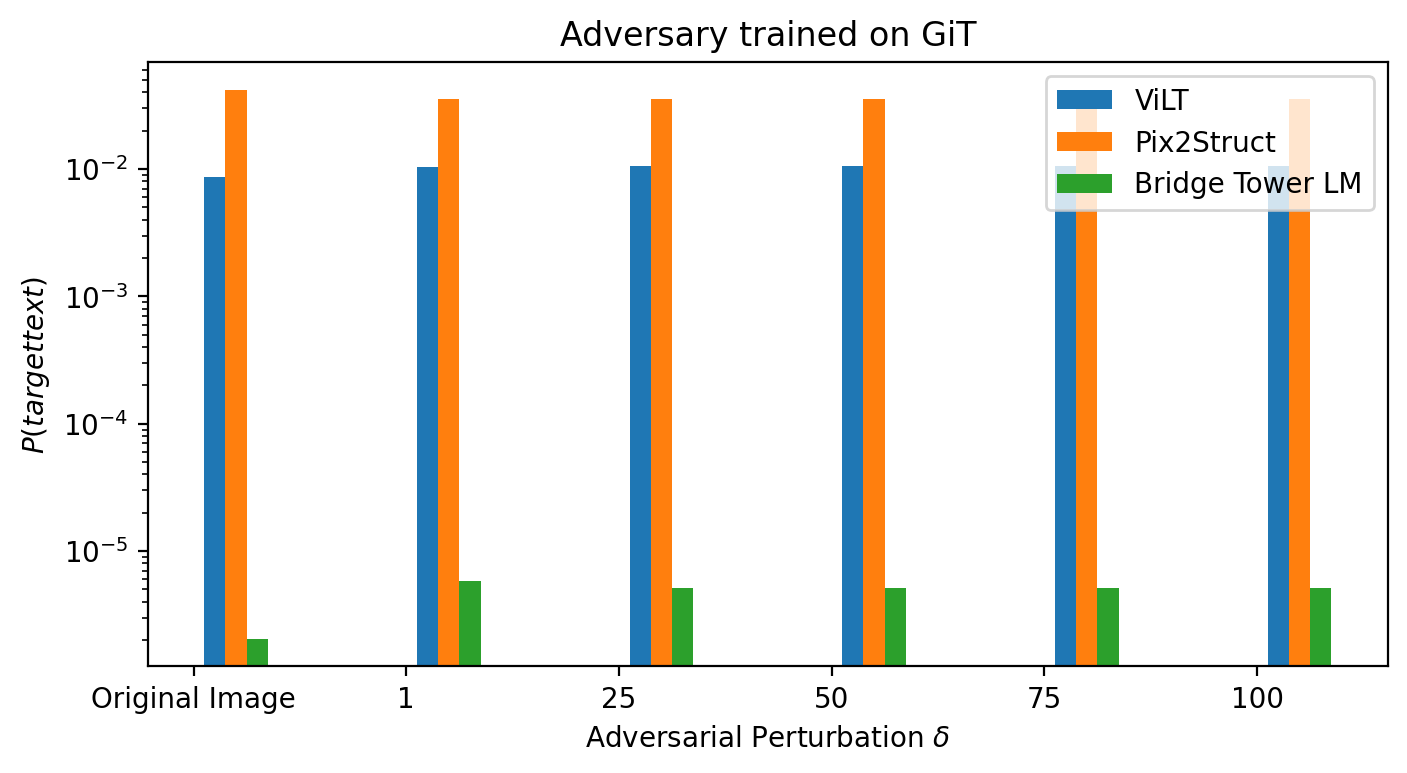

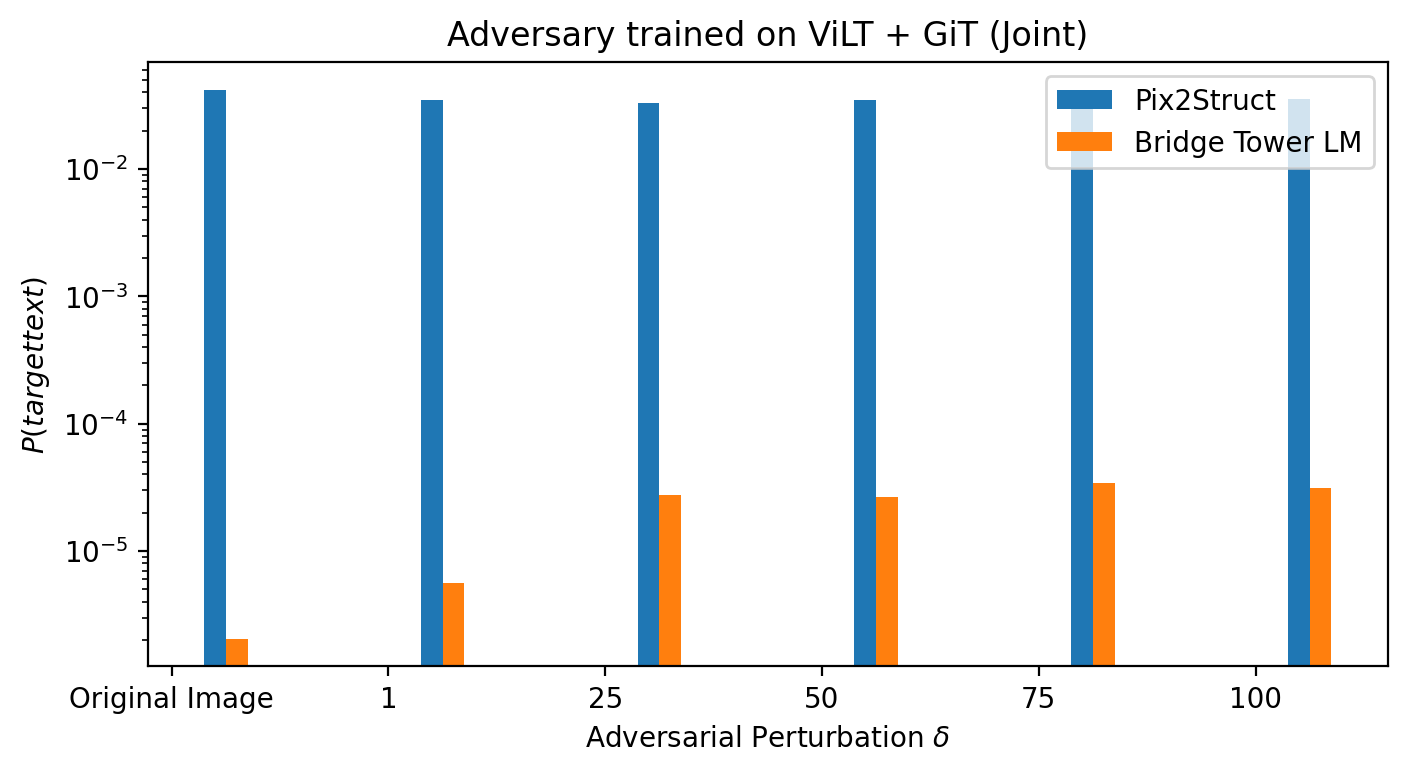

In [73]:
# Soft Transfer
fig_0, ax_0 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
fig_1, ax_1 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
percentages = ["Original Image", 1, 25, 50, 75, 100]
# Create a bar plot
for model_id, model_name in enumerate(transfer_data):
    data = transfer_data[model_name]
    if model_name not in ["GiT"]:
        ax_0.bar(model_id * 0.1 + np.arange(6), data["prob_single"], width=0.1, label=model_name)
    if model_name not in ["GiT", "ViLT"]:
        ax_1.bar(model_id * 0.1 + np.arange(6), data["prob_joint"], width=0.1, label=model_name)


ax_0.set_xlabel(r'Adversarial Perturbation $\delta$')
ax_0.set_ylabel(r'$P(target text)$')
ax_0.set_title('Adversary trained on GiT')

ax_1.set_xlabel(r'Adversarial Perturbation $\delta$')
ax_1.set_ylabel(r'$P(target text)$')
ax_1.set_title('Adversary trained on ViLT + GiT (Joint)')

# Set x-axis ticks
ax_0.set_xticks(range(6))
ax_0.set_xticklabels(percentages)
ax_0.legend()
ax_1.set_xticks(range(6))
ax_1.set_xticklabels(percentages)
ax_1.legend()

ax_0.set_yscale('log')
ax_1.set_yscale('log')
fig_0.savefig('transferprob_0.png')
fig_1.savefig('transferprob_1.png')
plt.show()

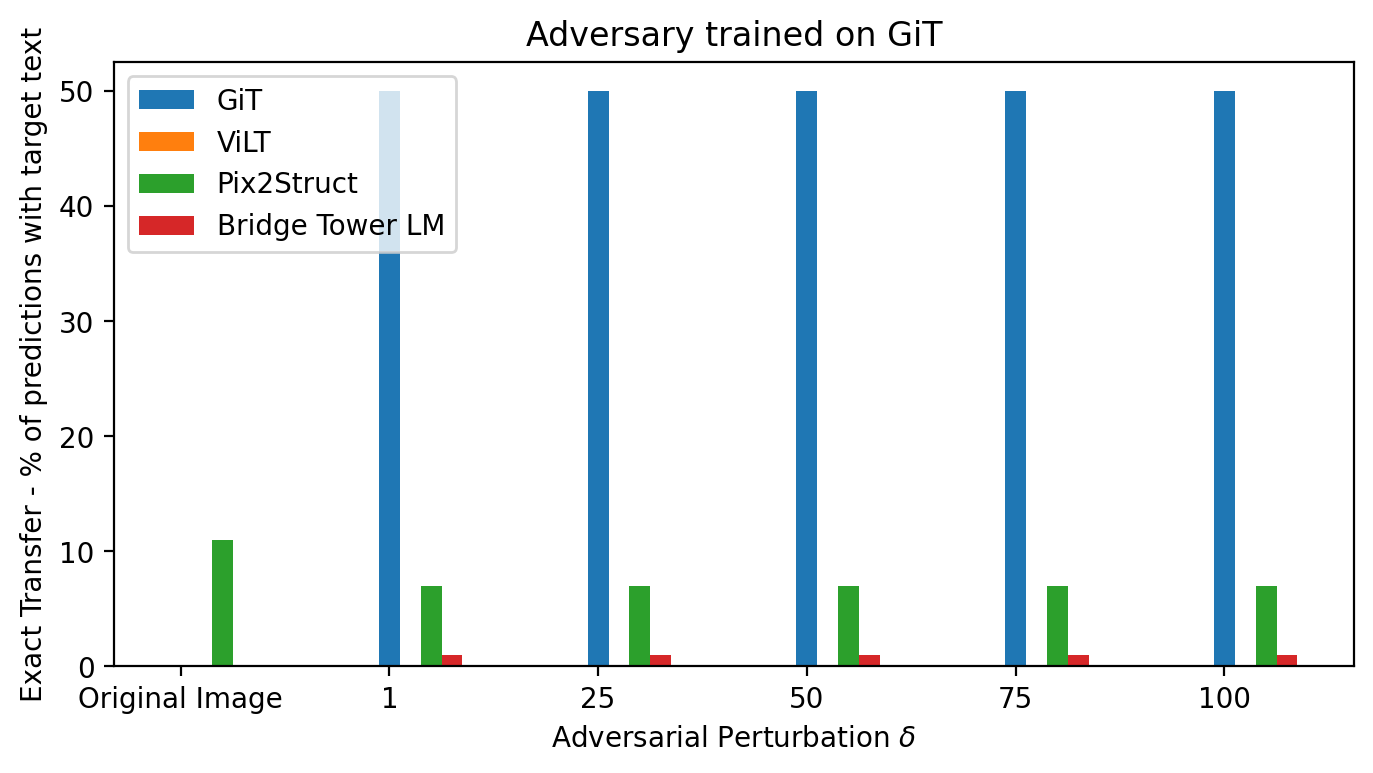

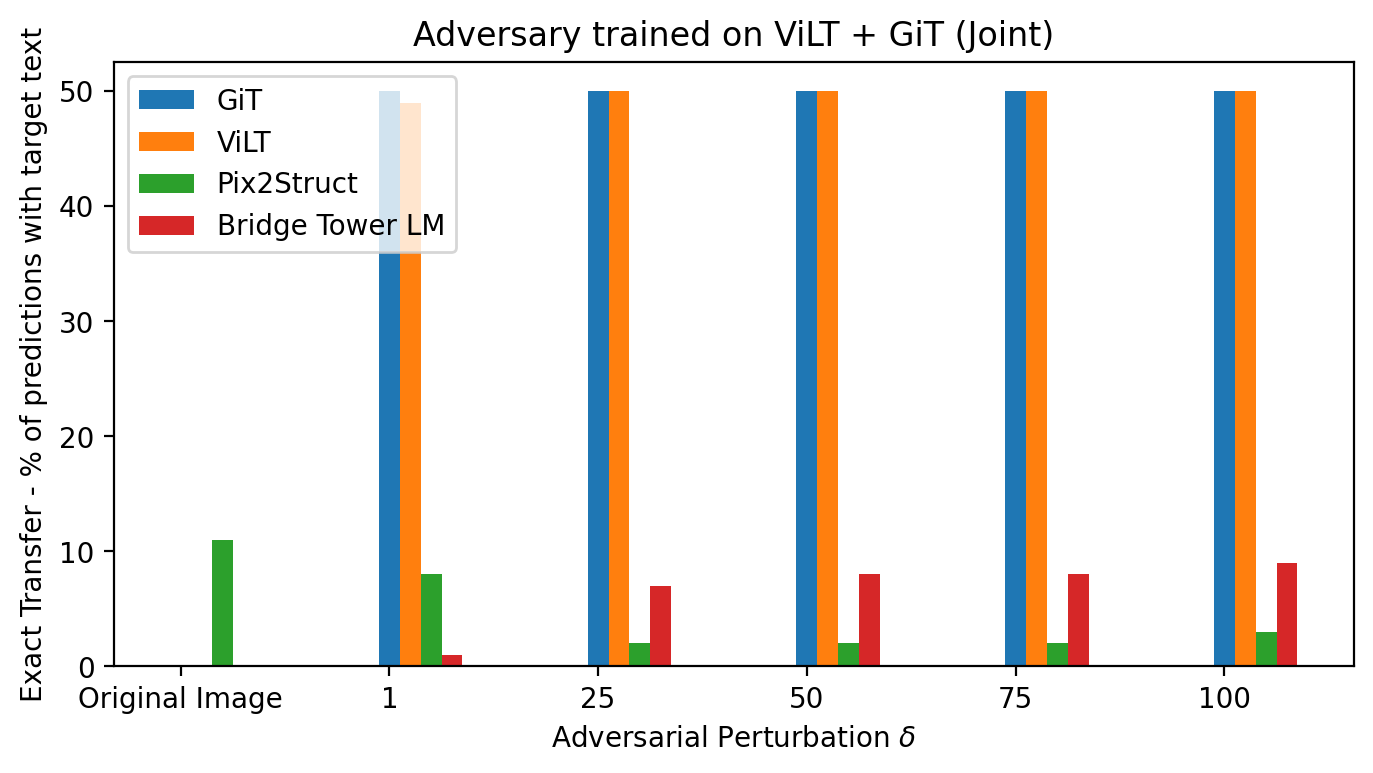

In [71]:
# Soft Transfer
fig_0, ax_0 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
fig_1, ax_1 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
percentages = ['Original Image', 1, 25, 50, 75, 100]
# Create a bar plot
for model_id, model_name in enumerate(transfer_data):
    data = transfer_data[model_name]
    ax_0.bar(model_id * 0.1 + np.arange(6), data["cat_single"], width=0.1, label=model_name)
    ax_1.bar(model_id * 0.1 + np.arange(6), data["cat_joint"], width=0.1, label=model_name)


ax_0.set_xlabel(r'Adversarial Perturbation $\delta$')
ax_0.set_ylabel(r'Exact Transfer - % of predictions with target text')
ax_0.set_title('Adversary trained on GiT')

ax_1.set_xlabel(r'Adversarial Perturbation $\delta$')
ax_1.set_ylabel(r'Exact Transfer - % of predictions with target text')
ax_1.set_title('Adversary trained on ViLT + GiT (Joint)')

# Set x-axis ticks
ax_0.set_xticks(range(6))
ax_0.set_xticklabels(percentages)
ax_0.legend()
ax_1.set_xticks(range(6))
ax_1.set_xticklabels(percentages)
ax_1.legend()


fig_0.savefig('transferexact_0.png')
fig_1.savefig('transferexact_1.png')
plt.show()

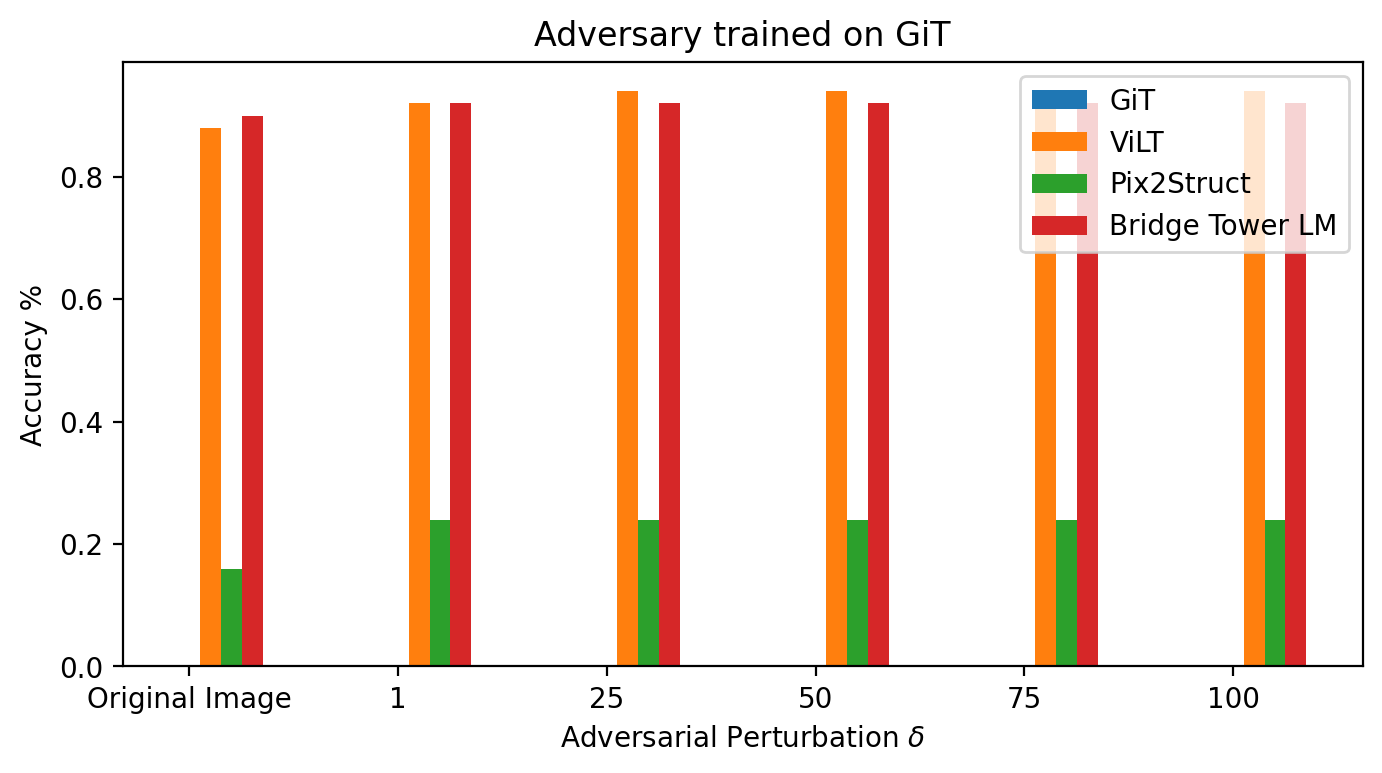

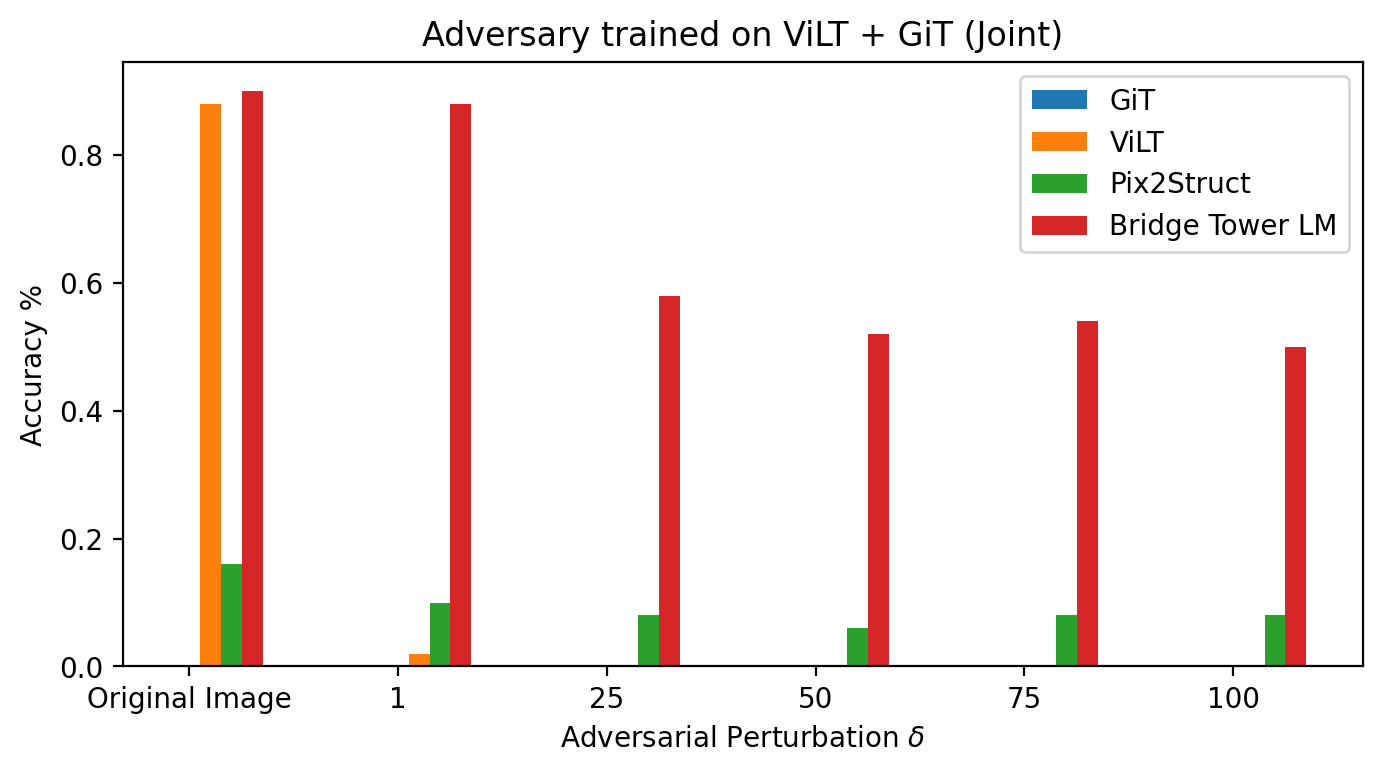

In [72]:
# Soft Transfer
fig_0, ax_0 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
fig_1, ax_1 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
percentages = ['Original Image', 1, 25, 50, 75, 100]
# Create a bar plot
for model_id, model_name in enumerate(transfer_data):
    data = transfer_data[model_name]
    ax_0.bar(model_id * 0.1 + np.arange(6), np.array(data["dog_single"]) / 50, width=0.1, label=model_name)
    ax_1.bar(model_id * 0.1 + np.arange(6), np.array(data["dog_joint"]) / 50, width=0.1, label=model_name)


ax_0.set_xlabel(r'Adversarial Perturbation $\delta$')
ax_0.set_ylabel(r'Accuracy %')
ax_0.set_title('Adversary trained on GiT')

ax_1.set_xlabel(r'Adversarial Perturbation $\delta$')
ax_1.set_ylabel(r'Accuracy %')
ax_1.set_title('Adversary trained on ViLT + GiT (Joint)')

# Set x-axis ticks
ax_0.set_xticks(range(6))
ax_0.set_xticklabels(percentages)
ax_0.legend()
ax_1.set_xticks(range(6))
ax_1.set_xticklabels(percentages)
ax_1.legend()

fig_0.savefig('transferaccuracy_0.png')
fig_1.savefig('transferaccuracy_1.png')
plt.show()